<a href="https://colab.research.google.com/github/zd2011/causal201/blob/main/lab13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 13 - Recitation - Sensitivity analyses

author: Judith Abécassis and Élise Dumas.

In this recitation, we will conduct several sensitivity analyses on the estimation of Average Treatment Effect of RHC (also called the Swan-Ganz catheter) as initial care on mortality for critic patients admitted to ICU. RHC consists in the insertion of a catherer into a pulmonary artery. It enables precise, direct and simultaneous measurement of heart pressures (right atrium, right ventricle, pulmonary artery, and the filling pressure).

Complete data description is available [here](https://hbiostat.org/data).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
import warnings
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings(action='once')
rg = np.random.default_rng(2907)

sns.set_context('poster')

# Exercise 1: load and prepare data

In [ ]:
#Load dataset
url = "https://hbiostat.org/data/repo/rhc.csv" 
df = pd.read_csv(url,index_col=0)
df.describe(include = "all")

,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,chfhx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
count,5735,1200,5735,5735.000000,5734.000000,3722.000000,5735.000000,5735,5735.000000,5735.000000,...,5735,5735,5735,5735,5735,1439.000000,2707.000000,5735,5735,5735.000000
unique,9,6,3,NaN,NaN,NaN,NaN,2,NaN,NaN,...,2,2,2,2,2,NaN,NaN,3,4,NaN
top,ARF,MOSF w/Sepsis,No,NaN,NaN,NaN,NaN,Yes,NaN,NaN,...,No,No,No,No,No,NaN,NaN,white,Under $11k,NaN
freq,2490,826,4379,NaN,NaN,NaN,NaN,3722,NaN,NaN,...,5470,5381,4704,5683,5728,NaN,NaN,4460,3226,NaN
mean,NaN,NaN,NaN,11638.686312,11660.050401,11753.869156,11781.257890,NaN,0.176635,0.178030,...,NaN,NaN,NaN,NaN,NaN,1.182071,2192.453665,NaN,NaN,5134.006452
std,NaN,NaN,NaN,513.967751,513.447322,538.812330,524.094168,NaN,0.381393,0.382571,...,NaN,NaN,NaN,NaN,NaN,1.819057,1525.140006,NaN,NaN,2972.206379
min,NaN,NaN,NaN,10754.000000,10757.000000,10757.000000,10756.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,5.000000
25%,NaN,NaN,NaN,11163.500000,11184.000000,11267.000000,11316.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,1110.000000,NaN,NaN,2561.500000
50%,NaN,NaN,NaN,11759.000000,11777.000000,11831.500000,11868.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,1927.000000,NaN,NaN,5131.000000
75%,NaN,NaN,NaN,12097.000000,12120.000000,12208.000000,12244.000000,NaN,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,2.000000,2955.000000,NaN,NaN,7689.000000


Variables description here : https://hbiostat.org/data/repo/Crhc.html

### 1. Create a variable death_90 which equals 1 if the patient is dead before 90 days (included) after ICU admission; and 0 otherwise.

In [ ]:
#Create a variable which equals delay (in day) between death date and date of admission.
df['delay_death_admission'] = df.dthdte - df.sadmdte
print(df.delay_death_admission.describe())

#Create variable death_90
df['death_90'] = np.where(df.delay_death_admission <= 90, 1, 0)
print(df.death_90.value_counts())
print(df.death.value_counts())

#Drop variable death and delay_death_admission
df = df.drop(["death","delay_death_admission"],axis = 1)

count    3722.000000
mean      162.235357
std       295.627507
min         2.000000
25%         8.000000
50%        28.000000
75%       166.000000
max      1943.000000
Name: delay_death_admission, dtype: float64
0    3228
1    2507
Name: death_90, dtype: int64
Yes    3722
No     2013
Name: death, dtype: int64


### 2. Remove variables with more than 25% missing values.

In [ ]:
col_to_remove = df.columns[df.isna().sum()/df.shape[0] > 0.25]
print(col_to_remove)
df = df.drop(col_to_remove,axis = 1)
df.head()

Index(['cat2', 'dthdte', 'adld3p', 'urin1'], dtype='object')


,cat1,ca,sadmdte,dschdte,lstctdte,cardiohx,chfhx,dementhx,psychhx,chrpulhx,...,renal,meta,hema,seps,trauma,ortho,race,income,ptid,death_90
1,COPD,Yes,11142,11151.0,11382,0,0,0,0,1,...,No,No,No,No,No,No,white,Under $11k,5,0
2,MOSF w/Sepsis,No,11799,11844.0,11844,1,1,0,0,0,...,No,No,No,Yes,No,No,white,Under $11k,7,1
3,MOSF w/Malignancy,Yes,12083,12143.0,12400,0,0,0,0,0,...,No,No,No,No,No,No,white,$25-$50k,9,0
4,ARF,No,11146,11183.0,11182,0,0,0,0,0,...,No,No,No,No,No,No,white,$11-$25k,10,1
5,MOSF w/Sepsis,No,12035,12037.0,12036,0,0,0,0,0,...,No,No,No,No,No,No,white,Under $11k,11,1


### 3. Dicard rows with remaining missing values.

In [ ]:
print(df.shape)
df = df.dropna()
print(df.shape)

(5735, 58)
(5734, 58)


### 4. Remove date columns (whose name contains dte) and variable ptid (which is patient ID)

In [ ]:
col_to_remove = df.filter(regex='dte|ptid').columns.to_numpy()
df = df.drop(col_to_remove,axis = 1)

# Exercise 2: IPW estimator for socio-demographic variables only.

In this exercice, we will assume that we only have access to socio-demograpgic variables at the date of admission in ICU (meaning that we are going to discard all medical variables for now).

### 1. Discard all medical variables. What do you think about conditional ignorability in this dataset?

In [ ]:
#Run this line.
df_restricted = df.drop(["cat1",'ca','cardiohx', 'chfhx', 'dementhx', 'psychhx', 'chrpulhx','renalhx', 'liverhx', 'gibledhx', 'malighx', 'immunhx', 'transhx',
       'amihx','surv2md1', 'das2d3pc', 't3d30', 'dth30',
       'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1', 'temp1', 'pafi1',
       'alb1', 'hema1', 'bili1', 'crea1', 'sod1', 'pot1', 'paco21', 'ph1',
       'wtkilo1', 'dnr1', 'ninsclas', 'resp', 'card', 'neuro',
       'gastr', 'renal', 'meta', 'hema', 'seps', 'trauma', 'ortho'],axis = 1)

In [ ]:
df_restricted.head()

,age,sex,edu,swang1,race,income,death_90
1,70.25098,Male,12.000000,No RHC,white,Under $11k,0
2,78.17896,Female,12.000000,RHC,white,Under $11k,1
3,46.09198,Female,14.069916,RHC,white,$25-$50k,0
4,75.33197,Female,9.000000,No RHC,white,$11-$25k,1
5,67.90997,Male,9.945259,RHC,white,Under $11k,1


**Answer** : conditional ignorabiliy is probably not satisfied in this dataset since important confounders such as the medical reason why the patient was admitted to ICU, patient comorbidities, etc.., are missing.

### 2. One-hot encode categorical features.

In [ ]:
#Categorical features are the one whose type is object (rather than float or integer).
#We do not want to one-hot encode treatment and outcome.
cat_columns = df_restricted.columns[(df_restricted.dtypes == "object") & ~df_restricted.columns.isin(["swang1","death_90"])]

#One hot encode categorical features.
df_restricted = pd.get_dummies(df_restricted, columns=cat_columns)

### 3. Derive propensity score using a logistic regression model.

In [ ]:
#Initiate the model
clf = make_pipeline(StandardScaler(), LogisticRegression())
#X : Dataframe without treatment and outcome
X = df_restricted.drop(['death_90','swang1'],axis = 1) 
#t : Treatment
t = df_restricted['swang1'] 
#Fit the model
clf.fit(X,t)

#Predict propensity score for each unit
df_restricted["propensity_score"] = clf.predict_proba(X)[:,1]
df_restricted.head()

,age,edu,swang1,death_90,sex_Female,sex_Male,race_black,race_other,race_white,income_$11-$25k,income_$25-$50k,income_> $50k,income_Under $11k,propensity_score
1,70.25098,12.000000,No RHC,0,0,1,0,0,1,0,0,0,1,0.374264
2,78.17896,12.000000,RHC,1,1,0,0,0,1,0,0,0,1,0.330582
3,46.09198,14.069916,RHC,0,1,0,0,0,1,0,1,0,0,0.421730
4,75.33197,9.000000,No RHC,1,1,0,0,0,1,1,0,0,0,0.348105
5,67.90997,9.945259,RHC,1,0,1,0,0,1,0,0,0,1,0.369607


### 4. Plot propensity scores density colored by treatment. What can you conclude?

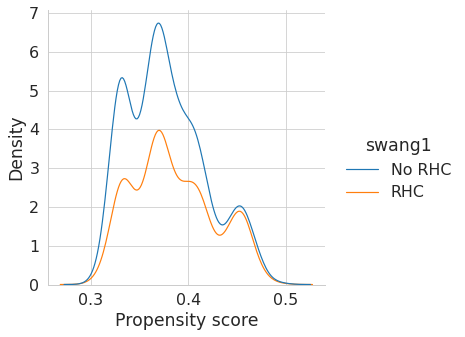

In [ ]:
#Plot configuration
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8) 

#Density plot
fig  = sns.displot(df_restricted, x="propensity_score", kind="kde", hue ="swang1")
fig.set_axis_labels('Propensity score', 'Density')

**Answer** : There is a good overlap between the two densities, but they do not cover the whole range of probability. Indeed, they range from 0.3 to 0.48. This implies that our estimate of treatment effect will not apply to patients whose propensity score is out of this range.

### 5. Estimate ATE using Hornitz-Thomson Estimator.

In [ ]:
#Estimate ATE using IPW estimator
df_restricted["swang1_bin"] = np.where(df_restricted.swang1=="RHC",1,0) #Convert treatment to 0/1 to ease derivations.
ate_hat = np.mean(df_restricted.swang1_bin*df_restricted.death_90/df_restricted.propensity_score - (1-df_restricted.swang1_bin)*df_restricted.death_90/(1-df_restricted.propensity_score))
print(f"Estimator for ATE : {ate_hat.round(4)}")

Estimator for ATE : 0.0879


### 6. Derive a 95% confidence interval around you ATE estimate using bootstrap (100 repetitions). What do you conclude?

In [ ]:
#%%capture --no-display #Discard warning display

#Use bootstrap to get a 95% estimate
N_boot=100 #Number of boostrap repetitions
ate_s_boot = np.empty(N_boot) #Numpy array to store boostrapped ATE estimations 
n = df.shape[0] #Number of rows in dataframe

for i in range(N_boot):
    
    #Simultate boostrapped dataset
    idx_boot = rg.choice(n, n, replace=True)
    sim_boot = df_restricted.loc[df_restricted.index[idx_boot]]
    
    #Compute propensity score
    clf = make_pipeline(StandardScaler(), LogisticRegression())
    X = sim_boot.drop(['death_90','swang1','swang1_bin'],axis = 1) #Dataframe without treatment and outcome (beware to remove swang1_bin as well)
    t = sim_boot['swang1'] #Treatment
    clf.fit(X,t)
    sim_boot["propensity_score"] = clf.predict_proba(X)[:,1]
    #Estimate ATE and add it to the array
    sim_boot.swang1_bin = np.where(sim_boot.swang1=="RHC",1,0)
    ate_s_boot[i] = np.mean(sim_boot.swang1_bin*sim_boot.death_90/sim_boot.propensity_score -
                            (1-sim_boot.swang1_bin)*sim_boot.death_90/(1-sim_boot.propensity_score))
    

In [ ]:
CI_low = ate_hat - sps.norm.ppf(0.975)*np.std(ate_s_boot)
CI_high = ate_hat + sps.norm.ppf(0.975)*np.std(ate_s_boot)
print(f"95%CI: [{CI_low.round(5)};{CI_high.round(5)}]")

95%CI: [0.06166;0.11405]


**Answer:** Our results suggest that the use RHC increases mortality by 8% on average. The results is significant at 95%.

# Exercise 3: Sensitivity analyses for unmeasured confounders.

Let's conduct sensitivity analyses to robustness of our results to propensity score changes. We suppose that there is an unboserved confounder which affects treatment assignment (for instance medical reason for entering ICU). 

### 1. We assume that for all units the distance between the inferred propensity score and true propensity score is lower than a certain threshold. Compute lower and upper bound for your ATE estimate using the formula we derived in class. Test for several thresholds. Comment on your findings.

In [ ]:
threshold = 0.1
lower_bound = np.mean(df_restricted.swang1_bin*df_restricted.death_90/(df_restricted.propensity_score+threshold) - 
                      (1-df_restricted.swang1_bin)*df_restricted.death_90/(1-df_restricted.propensity_score-threshold))
upper_bound = np.mean(df_restricted.swang1_bin*df_restricted.death_90/(df_restricted.propensity_score-threshold) - 
                      (1-df_restricted.swang1_bin)*df_restricted.death_90/(1-df_restricted.propensity_score+threshold))
print(f"Bounds for ATE estimate : [{lower_bound.round(5)};{upper_bound.round(5)}]")

Bounds for ATE estimate : [-0.09458;0.32646]


**Answer**: ATE bounds seem to contain zero for all thresholds above 0.05 or so. This suggests that even a tiny change in propensity score may affect the significance of our previous result.

### 2. Plot your lower and upper bounds for 100 values of threshold in between 0 and 0.25.

In [ ]:
#Values of threshold to test: 100 points between 0 and 0.25
threshold_to_test = np.linspace(0,0.25,100)

#Create list to store lower and upper bounds.
lower_bound_tot = []
upper_bound_tot = []

#Loop on thresholds and fill the two lists.
for threshold in threshold_to_test : 
    lower_bound_tot.append(np.mean(df_restricted.swang1_bin*df_restricted.death_90/(df_restricted.propensity_score+threshold) - 
                      (1-df_restricted.swang1_bin)*df_restricted.death_90/(1-df_restricted.propensity_score-threshold)))
    upper_bound_tot.append(np.mean(df_restricted.swang1_bin*df_restricted.death_90/(df_restricted.propensity_score-threshold) - 
                      (1-df_restricted.swang1_bin)*df_restricted.death_90/(1-df_restricted.propensity_score+threshold)))

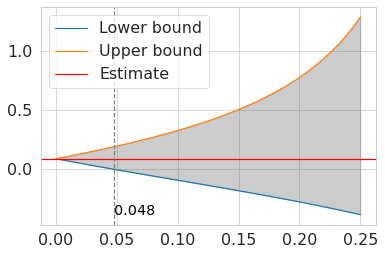

In [ ]:
#Plot lines for lower and upper bounds.
sns.lineplot(x=threshold_to_test, y = lower_bound_tot, label = "Lower bound")
sns.lineplot(x=threshold_to_test, y = upper_bound_tot, label = "Upper bound")

#Fill in grey in between the two lines
plt.fill_between(threshold_to_test, lower_bound_tot, upper_bound_tot, color ="grey",alpha=0.4)

#Add a horizontal line at ATE estimate.
plt.axhline(ate_hat, c= "red", linestyle = "-",label = "Estimate")

#Add a vertical line at the first point where lower bound is below 0 and write the threshold.
first_time_zero = np.argwhere(np.array(lower_bound_tot)<=0)[0]
plt.axvline(threshold_to_test[first_time_zero], c= "grey", linestyle = "--")
plt.text(threshold_to_test[first_time_zero],min(lower_bound_tot), threshold_to_test[first_time_zero].round(4)[0],
         horizontalalignment='left', size='small', color='black')

#Add legend
plt.legend()
plt.show()

# Exercise 4: IPW with all available variables (optional).

Let's now use all the available variables (socio-demographic and medical).

### Reproduce your code above to compute your ATE estimator

In [ ]:
##Categorical features are the one whose type is object (rather than float or integer).
#We do not want to one-hot encode treatment and outcome.
cat_columns = df.columns[(df.dtypes == "object") & ~df.columns.isin(["swang1","death_90"])]

#One hot encode categorical features.
df = pd.get_dummies(df, columns=cat_columns)

In [ ]:
#Initiate the model
clf = make_pipeline(StandardScaler(), LogisticRegression())
#X : Dataframe without treatment and outcome
X = df.drop(['death_90','swang1'],axis = 1) 
#t : Treatment
t = df['swang1'] 
#Fit the model
clf.fit(X,t)

#Predict propensity score for each unit
df["propensity_score"] = clf.predict_proba(X)[:,1]
df.head()

,cardiohx,chfhx,dementhx,psychhx,chrpulhx,renalhx,liverhx,gibledhx,malighx,immunhx,...,ortho_No,ortho_Yes,race_black,race_other,race_white,income_$11-$25k,income_$25-$50k,income_> $50k,income_Under $11k,propensity_score
1,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0.331538
2,1,1,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,1,0.649490
3,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,1,0,1,0,0,0.597943
4,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,0.344871
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0.479272


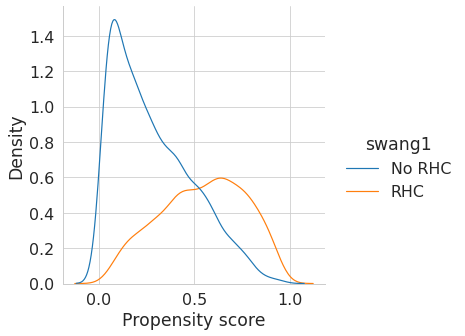

In [ ]:
#Plot configuration
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8) 

#Density plot
fig  = sns.displot(df, x="propensity_score", kind="kde", hue ="swang1")
fig.set_axis_labels('Propensity score', 'Density')

**Asnwer** Propensity score now ranges from 0 to 1 but overlap is not as good as before.

In [ ]:
#Estimate ATE using IPW estimator
df.swang1_bin = np.where(df.swang1=="RHC",1,0) #Convert treatment to 0/1 to ease derivations.
ate_hat = np.mean(df.swang1_bin*df.death_90/df.propensity_score - (1-df.swang1_bin)*df.death_90/(1-df.propensity_score))
print(f"Estimator for ATE : {ate_hat.round(4)}")

Estimator for ATE : -0.0091


<ipython-input-21-c84be28cb224>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.swang1_bin = np.where(df.swang1=="RHC",1,0) #Convert treatment to 0/1 to ease derivations.


**Asnwer** Our estimate of ATE is much lower (2% mortality increase).

In [ ]:
#%%capture --no-display #Discard warning display

#Use bootstrap to get a 95% estimate
N_boot=100 #Number of boostrap repetitions
ate_s_boot = np.empty(N_boot) #Numpy array to store boostrapped ATE estimations 
n = df.shape[0] #Number of rows in dataframe

for i in range(N_boot):
    
    #Simultate boostrapped dataset
    idx_boot = rg.choice(n, n, replace=True)
    sim_boot = df.loc[df.index[idx_boot]]
    
    #Compute propensity score
    clf = make_pipeline(StandardScaler(), LogisticRegression())
    X = sim_boot.drop(['death_90','swang1'],axis = 1) #Dataframe without treatment and outcome
    t = sim_boot['swang1'] #Treatment
    clf.fit(X,t)
    sim_boot["propensity_score"] = clf.predict_proba(X)[:,1]
    #Estimate ATE and add it to the array
    sim_boot.swang1_bin = np.where(sim_boot.swang1=="RHC",1,0)
    ate_s_boot[i] = np.mean(sim_boot.swang1_bin*sim_boot.death_90/sim_boot.propensity_score -
                            (1-sim_boot.swang1_bin)*sim_boot.death_90/(1-sim_boot.propensity_score))
    

<ipython-input-22-dbd566dac6d9>:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sim_boot.swang1_bin = np.where(sim_boot.swang1=="RHC",1,0)
<ipython-input-22-dbd566dac6d9>:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sim_boot.swang1_bin = np.where(sim_boot.swang1=="RHC",1,0)
<ipython-input-22-dbd566dac6d9>:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sim_boot.swang1_bin = np.where(sim_boot.swang1=="RHC",1,0)
<ipython-input-22-dbd566dac6d9>:21: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sim_boot.swang1_bin

In [ ]:
CI_low = ate_hat - sps.norm.ppf(0.975)*np.std(ate_s_boot)
CI_high = ate_hat + sps.norm.ppf(0.975)*np.std(ate_s_boot)
print(f"95%CI: [{CI_low.round(5)};{CI_high.round(5)}]")

95%CI: [-0.03804;0.01985]


**Answer** Result is not significant anymore, showing that we are unable to reject the null hypothesis. 